# Test the `MGCS_pytools` module

Import

In [1]:
import os
import pandas as pd
import numpy as np

import sys

sys.path.append(os.path.dirname(os.getcwd()))

from importlib import reload

In [45]:
import utils.plotting as utplot

reload(utplot)

<module 'utils.plotting' from '/home/linux-machine/work/MGCS_pytools/utils/plotting.py'>

## Membership probability

In [3]:
import statistical_membership.membership as stat_mem

In [4]:
CATALOG_PATH = os.path.join(
    os.getcwd(), "NGC6749.CAT.v1"
)  # Replace with the actual path to your catalog
OUTPUT_PATH = os.getcwd()  # Replace with the actual path to your output directory

In [5]:
# v1cat = "/home/linux-machine/NGC6749/NGC6749.CAT.v1"

df_cat_v1 = pd.read_csv(CATALOG_PATH, sep="\s+")
df_cat_v1 = df_cat_v1[df_cat_v1["oktot(54)"] == 1]
df_cat_v1["membership"] = 0.0

cluster_mag = ["m6061c(6)", "m8141c(7)"]
cluster_mag_corr = [col + "_drcorr" for col in cluster_mag]
field_mag = ["m6062c(8)", "m8142c(9)"]

df_field = df_cat_v1[df_cat_v1[field_mag[0]] != 0.0]
df_cluster = df_cat_v1[df_cat_v1[cluster_mag[0]] != 0.0]

fov_wfc3 = 163.0**2  # arcsec squared
fov_acs = 202.0**2  # arcsec squared

In [6]:
# reload(stat_mem)

# setting up the parameters for the reddening correction
dr_params = {
    "rband1": 0.903,
    "rband2": 0.597,
    "TO_mag": 22,
    "TO_color": 1.75,
    "nref": 20,
    "xcol": "x(3)",
    "ycol": "y(4)",
    "band1": cluster_mag[0],
    "band2": cluster_mag[1],
    "ord_step": 0.2,
}

ord_max = 0.4  # 0.40
ord_min = -0.05  # -2.0  # -0.05
roi = np.array([[1.0, ord_max], [2.1, ord_max], [0.3, ord_min], [-0.2, ord_min]])
# roi = np.array([[-0.8, ord_max], [0, ord_max], [-4, ord_min], [-5, ord_min]])

# compute ememberhsip and reddening correction
df_cluster_corr = stat_mem.do_statistical_membership(
    df_cluster,
    df_field,
    field_mag,
    dr_params,
    racol="ra(1)",
    deccol="dec(2)",
    fov_ratio=fov_acs / fov_wfc3,
    roi=roi,
    minstars=1000,
    memebership_iter=100,
    member_threshold=0.9,
    plot_dred=False,
    plot_voronoi=False,
)

Star density: 0.14 stars / arcsec^2 Min area for at least 1000 stars: 7092.94 arcsec^2
ITERATION 1
compute differential reddening..
count    50097.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: membership, dtype: float64
First iteration, correction threshold skipped
...differential reddening completed
EBV stat: 0.0068, -0.1171, 0.1466
Start decontamionation process..
	#### GROUP N.1 ####
	Membership (mean, min, max): (0.8271, 0.0000, 0.9900)


	#### GROUP N.2 ####
	Membership (mean, min, max): (0.8073, 0.0000, 0.9900)


	#### GROUP N.3 ####
	Membership (mean, min, max): (0.7945, 0.0000, 0.9900)


	#### GROUP N.4 ####
	Membership (mean, min, max): (0.7798, 0.0000, 0.9900)


	#### GROUP N.5 ####
	Membership (mean, min, max): (0.7549, 0.0000, 0.9900)


	#### GROUP N.6 ####
	Membership (mean, min, max): (0.7332, 0.0000, 0.9900)


ITERATION 2
compute differential reddening..
count    50097.000000
mean         0.

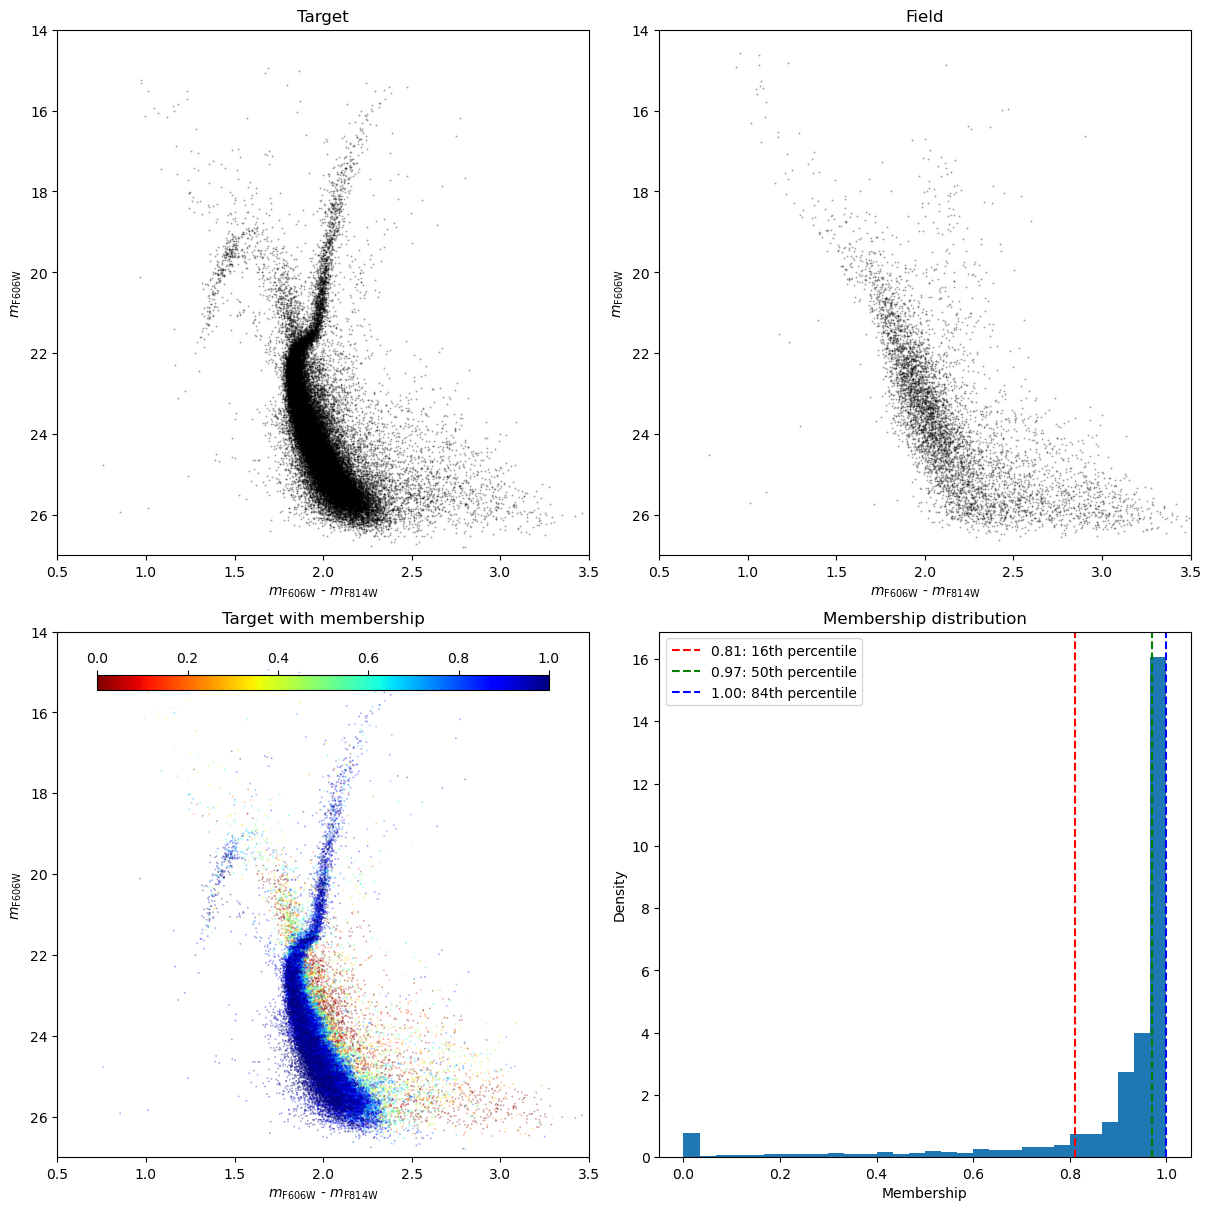

In [22]:
_ = utplot.plot_membership_overview(
    df_cluster_corr[cluster_mag_corr[0]],
    df_cluster_corr[cluster_mag_corr[1]],
    df_field[field_mag[0]],
    df_field[field_mag[1]],
    df_cluster_corr["membership"],
    blabel="$m_{\mathrm{F606W}}$",
    vlabel="$m_{\mathrm{F814W}}$",
    xlim=(0.5, 3.5),
    ylim=(27, 14),
)

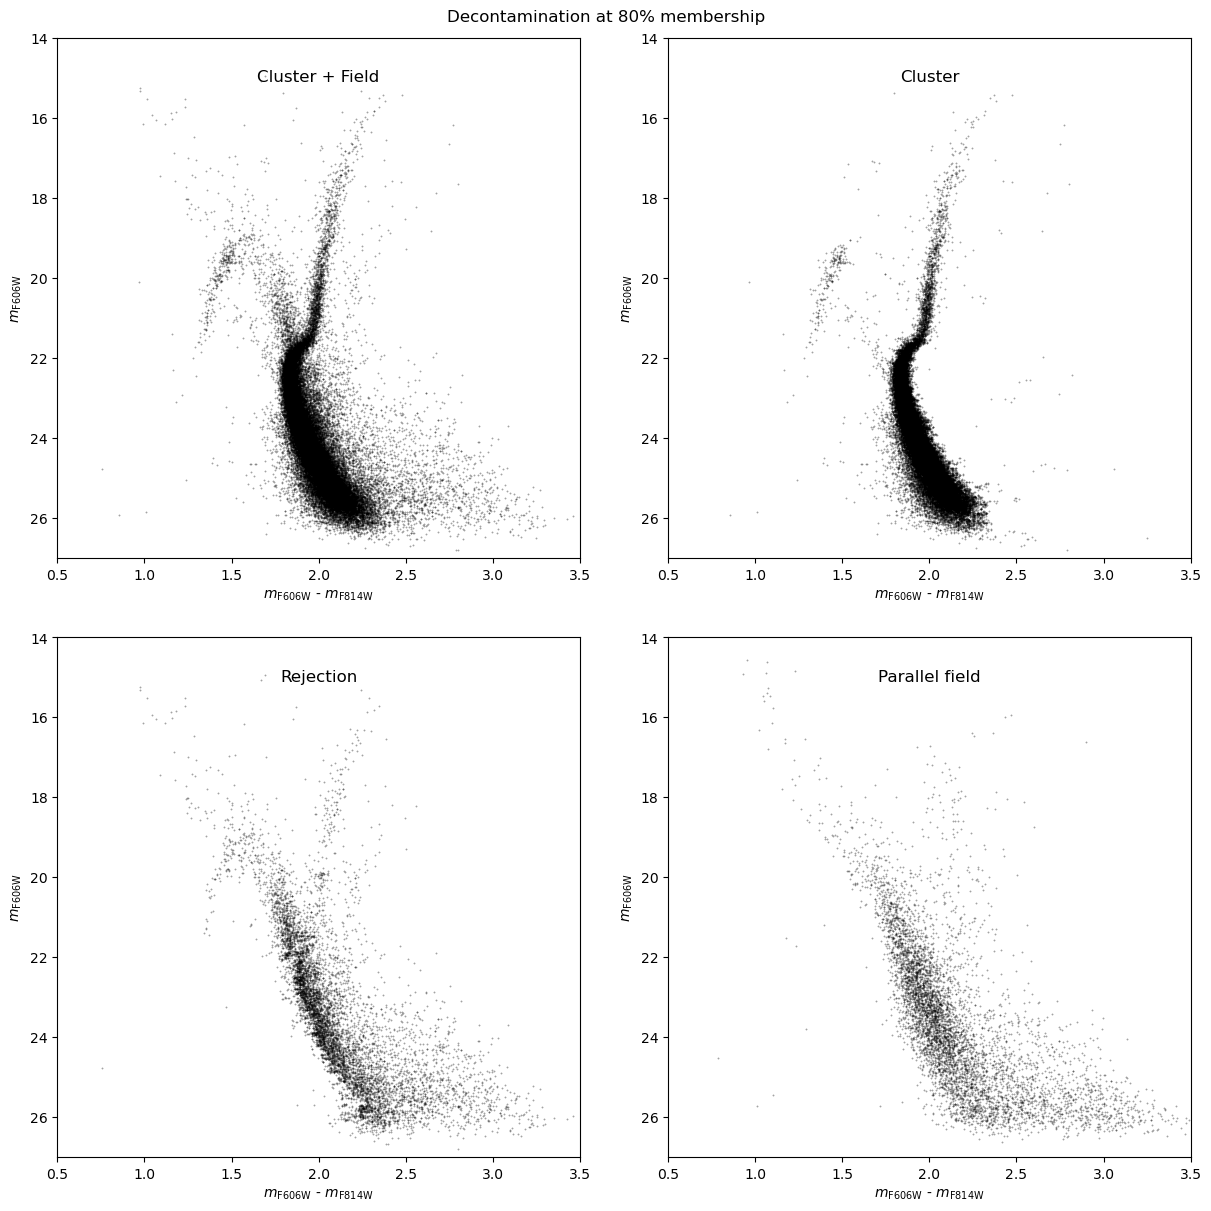

In [23]:
_ = utplot.plot_decontamination_snapshot(
    df_cluster_corr[cluster_mag_corr[0]],
    df_cluster_corr[cluster_mag_corr[1]],
    df_field[field_mag[0]],
    df_field[field_mag[1]],
    df_cluster_corr["membership"],
    member_threshold=0.8,
    blabel="$m_{\mathrm{F606W}}$",
    vlabel="$m_{\mathrm{F814W}}$",
    xlim=(0.5, 3.5),
    ylim=(27, 14),
)

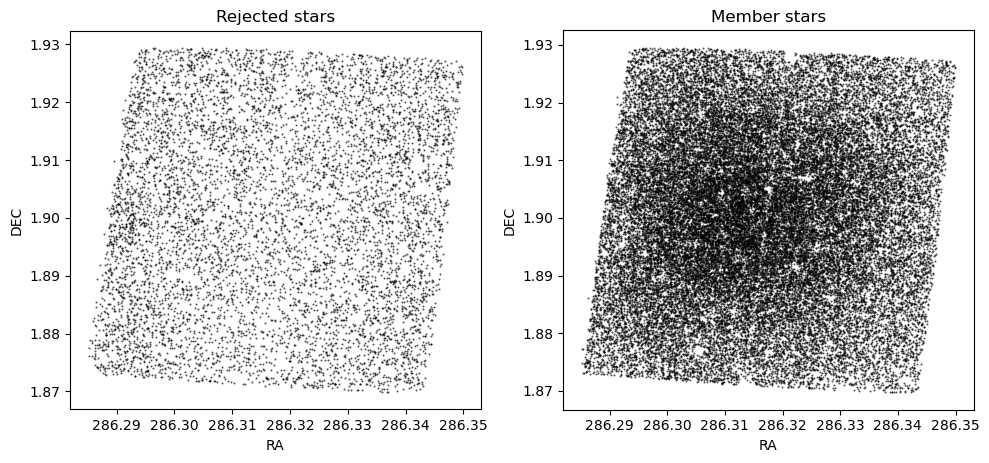

In [24]:
_ = utplot.plot_spatial_membership(
    df_cluster_corr["ra(1)"],
    df_cluster_corr["dec(2)"],
    df_cluster_corr["membership"],
    member_threshold=0.8,
)

In [25]:
ra_center = (
    df_cluster["ra(1)"].min()
    + (df_cluster["ra(1)"].max() - df_cluster["ra(1)"].min()) / 2
)
dec_center = (
    df_cluster["dec(2)"].min()
    + (df_cluster["dec(2)"].max() - df_cluster["dec(2)"].min()) / 2
)

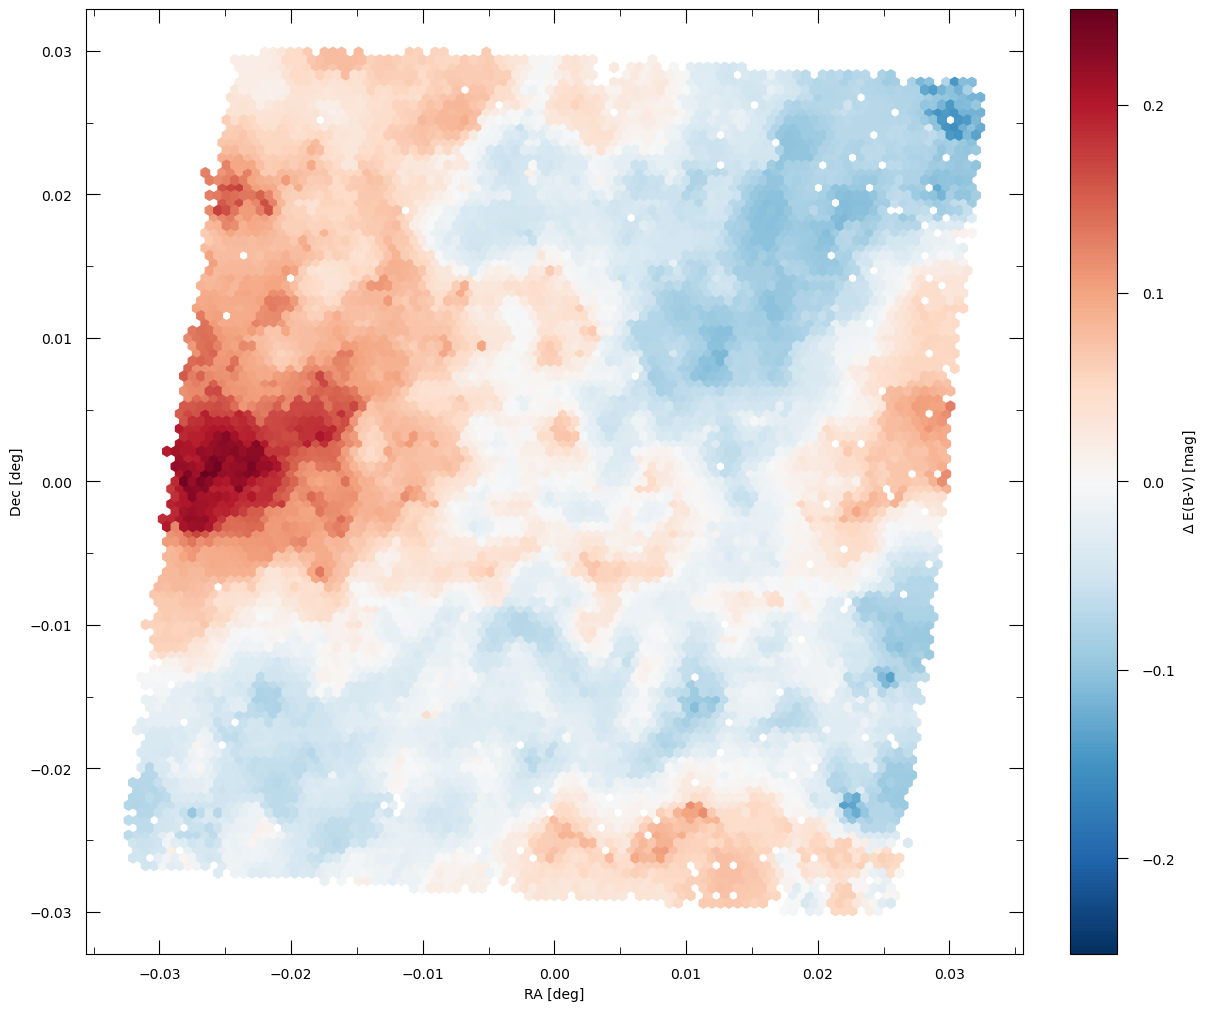

In [26]:
_ = utplot.plot_reddening_map(
    df_cluster_corr["ra(1)"],
    df_cluster_corr["dec(2)"],
    ra_center,
    dec_center,
    df_cluster_corr["delta_ebv"],
)

## Kinematic analysis

In [30]:
from mcmc import mcmc

reload(mcmc)

<module 'mcmc.mcmc' from '/home/linux-machine/work/MGCS_pytools/mcmc/mcmc.py'>

In [31]:
CATALOG_PATH = os.path.join(
    os.getcwd(), "NGC6749_GAIAHUB_REWIND_CORR.csv"
)  # Replace with the actual path to your catalog

In [32]:
df = pd.read_csv(CATALOG_PATH)

SIG_THRESHOLD = 2 * 0.33151780269010644

filter_df = df[
    (df["hst_gaia_pmra_wmean_corr_error"].abs() < SIG_THRESHOLD)
    & (df["hst_gaia_pmdec_wmean_corr_error"].abs() < SIG_THRESHOLD)
    & (df["oktot(54)"] == 1)
].copy()

In [33]:
# run parameters
nwalkers = 50
nsteps = 1000

# sample.chian parameters
discard = 500
thin = 10
flat = True

# priors
qmin = np.array([-4.0, -7.0, 0.0, 0.0, -1.0, -4.0, -7.0, 1.0, 1.0, -1.0, 0.0])
qmax = np.array([-2.0, -5.0, 2.0, 2.0, 1.0, -1.0, -3.0, 3.0, 3.0, 1.0, 1.0])

# linked parameters
lnk_params = np.array([(2, 3)])

# fix parameters
fix_params = np.full(qmin.size, np.nan)
fpi = np.array([4])
fix_params[fpi] = 0.0

colra = "hst_gaia_pmra_wmean_corr"
coldec = "hst_gaia_pmdec_wmean_corr"
colrae = "hst_gaia_pmra_wmean_corr_error"
coldece = "hst_gaia_pmdec_wmean_corr_error"

In [34]:
gh_emcee = mcmc.MyEmceeES(
    data=filter_df[
        [
            colra,
            coldec,
            colrae,
            coldece,
        ]
    ].values,
    pmodel="multivariate_2d",
    nwalkers=50,
    nsteps=1000,
    ncomp=2,
    par_per_comp=5,
    qmin=qmin,
    qmax=qmax,
)
gh_emcee.run_emcee(parallel=True)

100%|██████████| 1000/1000 [01:12<00:00, 13.79it/s]


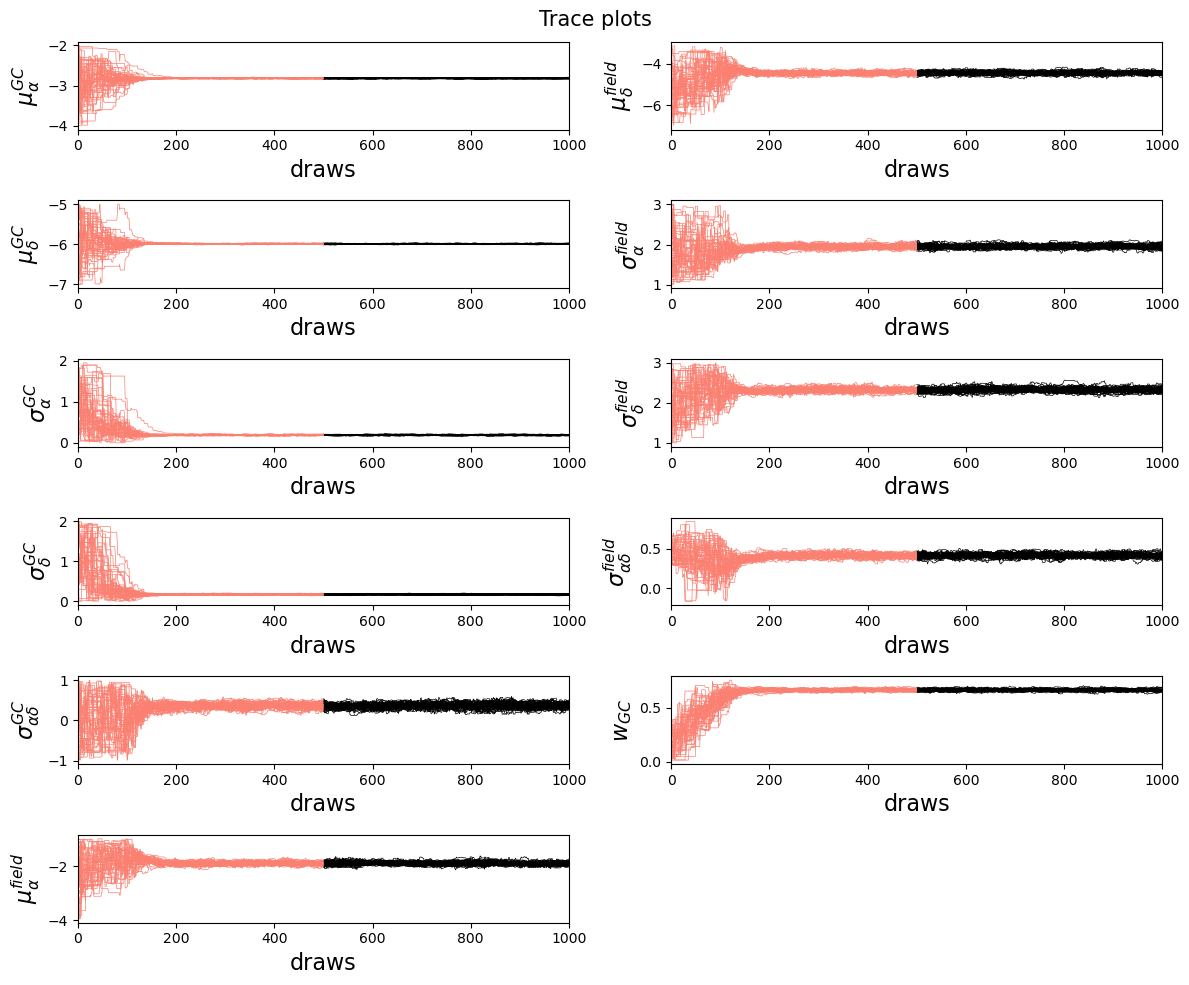

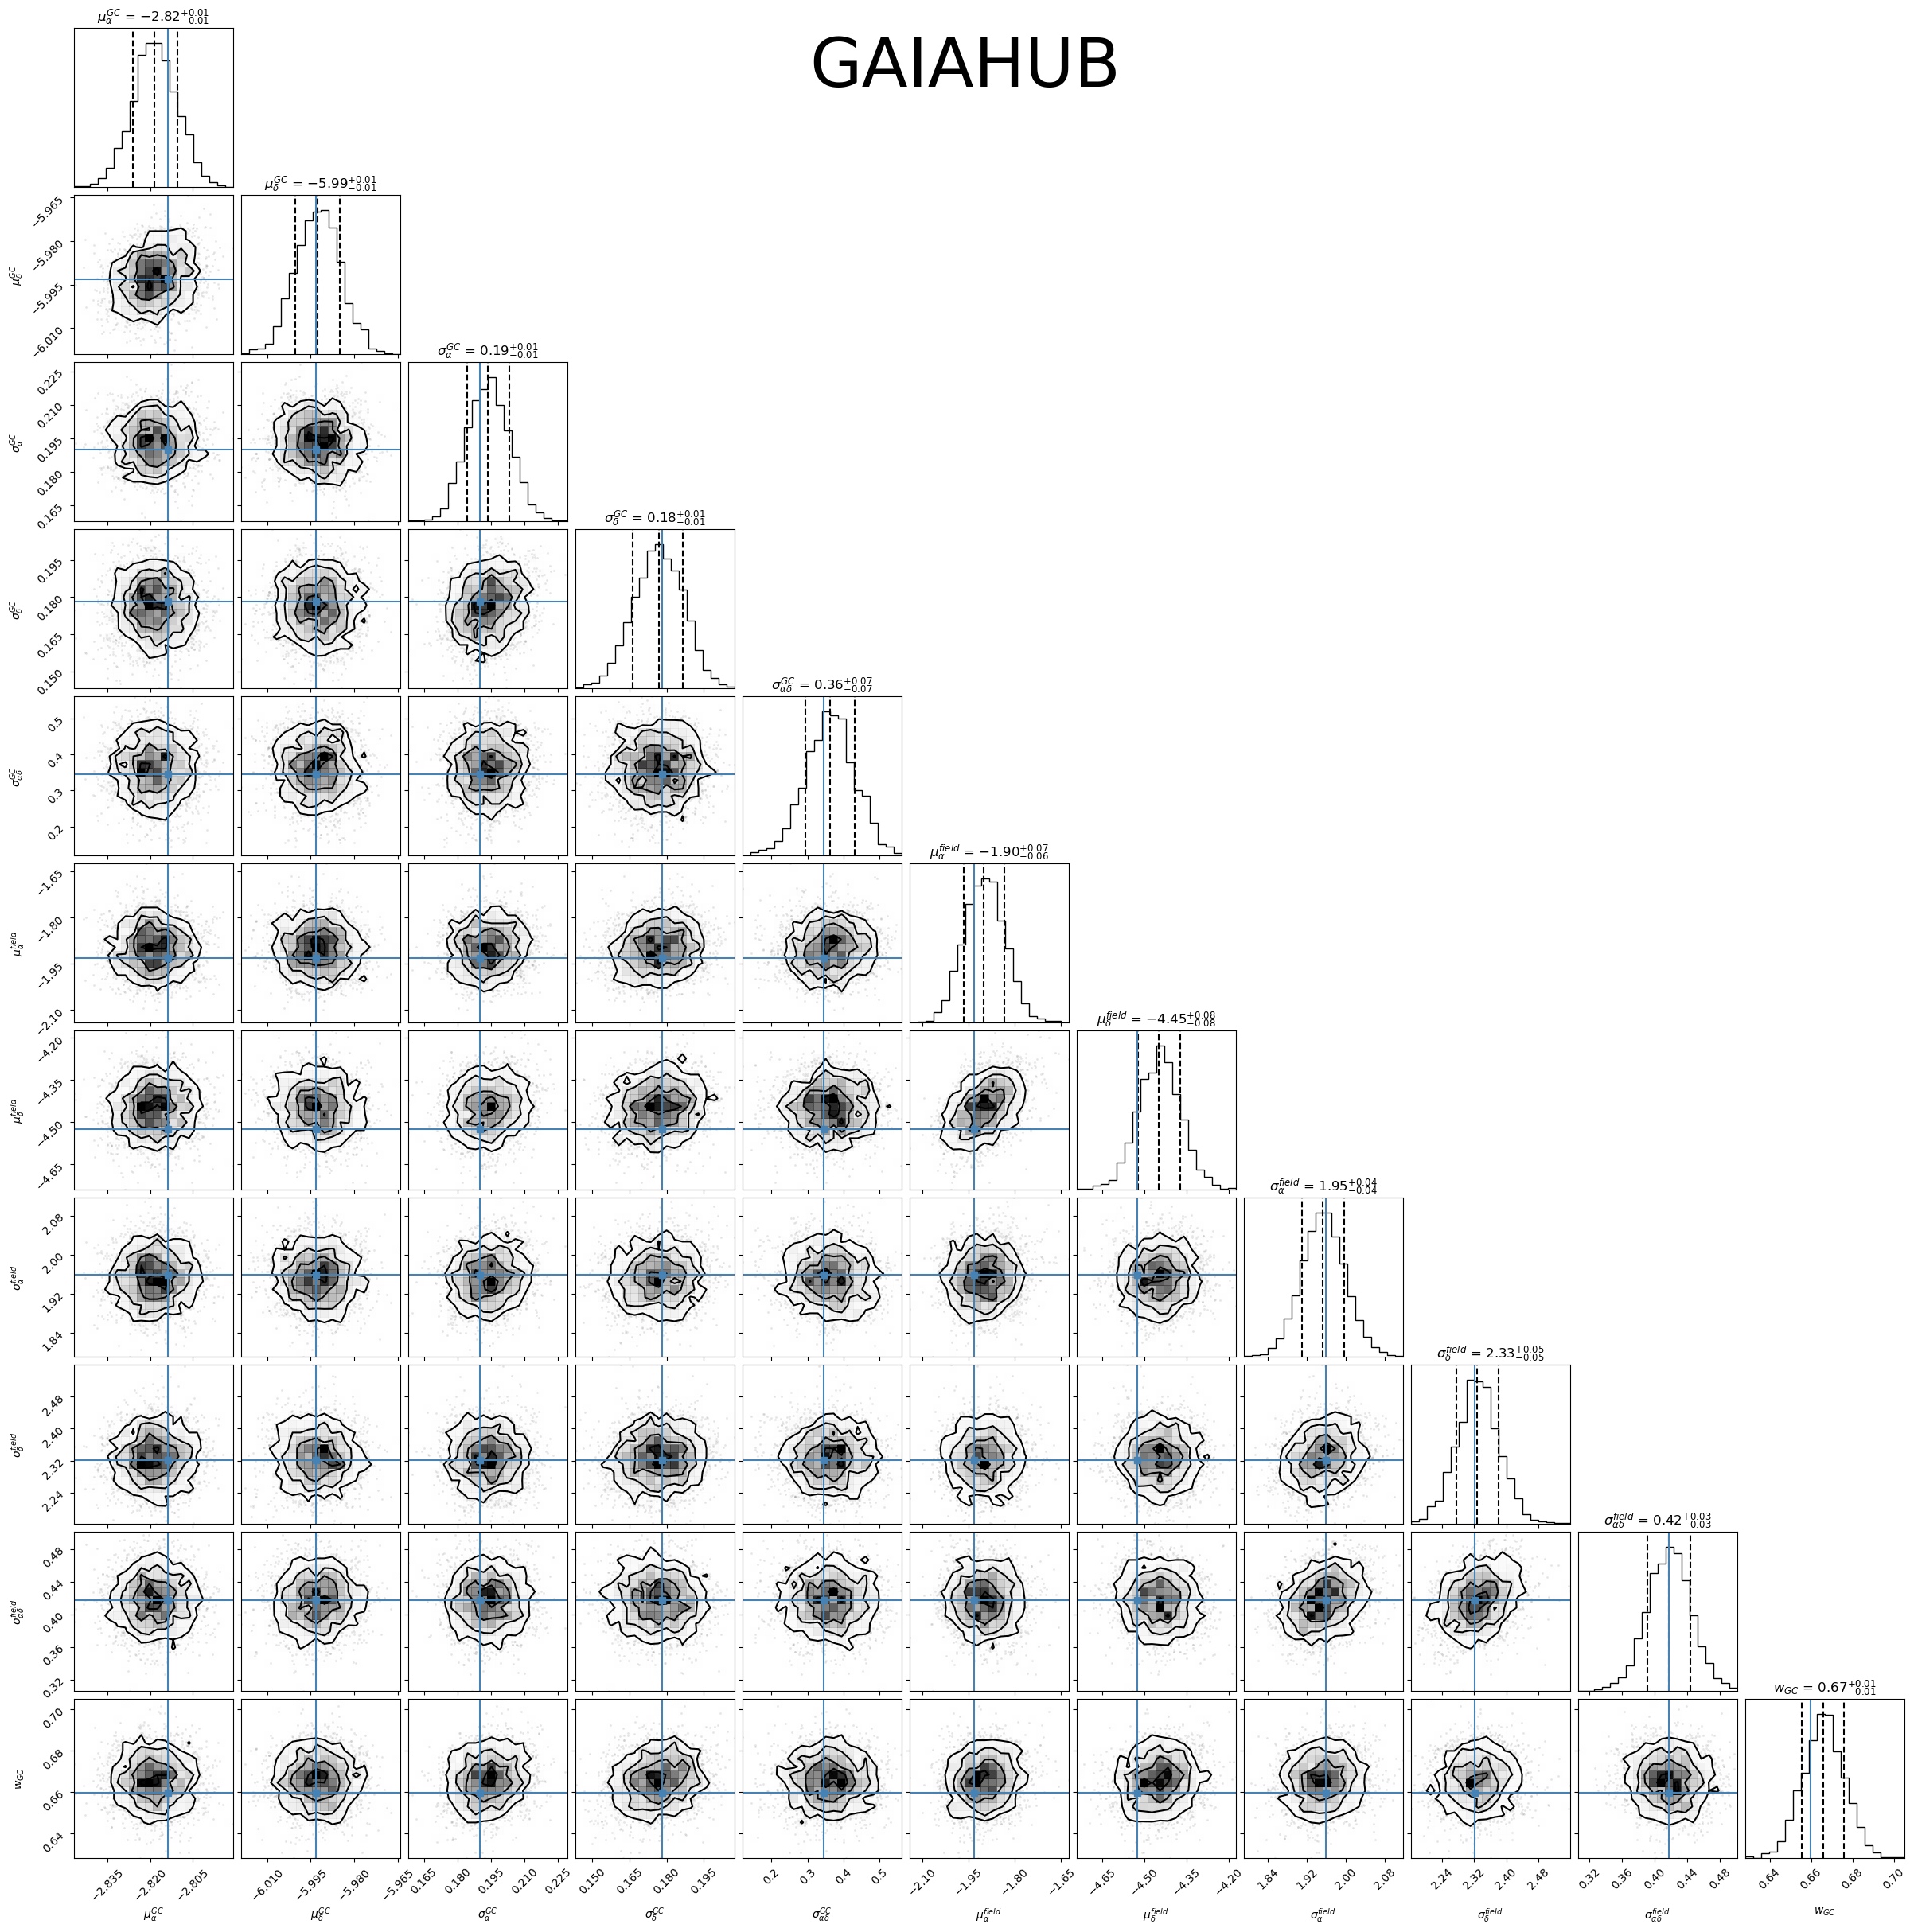

In [48]:
params = [
    r"$\mu_\alpha^{GC}$",
    r"$\mu_\delta^{GC}$",
    r"$\sigma_\alpha^{GC}$",
    r"$\sigma_\delta^{GC}$",
    r"$\sigma_{\alpha\delta}^{GC}$",
    r"$\mu_\alpha^{field}$",
    r"$\mu_\delta^{field}$",
    r"$\sigma_\alpha^{field}$",
    r"$\sigma_\delta^{field}$",
    r"$\sigma_{\alpha\delta}^{field}$",
    r"$w_{GC}$",
]

ch = gh_emcee.get_chain(flat=flat, thin=thin, discard=discard)
truths = gh_emcee.get_chpars(discard=discard, thin=thin, which="maxln", flat=flat)

# Trace plots
fig = utplot.traceplots(gh_emcee.get_chain(), labels=params, burnin=discard)
fig.set_size_inches(12, 10)
fig.set_tight_layout(True)

# corner plots
fig = utplot.plot_corner(chain=ch, labels=params, title="GAIAHUB", truths=truths)